# Deep Learning and Single-Cell Phenotyping for Rapid Antimicrobial Susceptibility Testing - Training Notebook

This notebook provides the necessary steps to set up the environment, download the dataset, and train the segmentation and classification models from the provided repository.

**Note:** Training deep learning models can be computationally intensive and may require a GPU runtime. Ensure you have selected a GPU runtime in Colab (Runtime -> Change runtime type -> GPU).

## 1. Clone the Repository

In [1]:
# Ensure the repo is available in the runtime
from pathlib import Path
import os

# Set `IC_REPO_URL` to your fork (recommended) so Colab clones your modified pipeline.
# Example:
#   %env IC_REPO_URL=https://github.com/<you>/Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing.git
DEFAULT_REPO_URL = "https://github.com/mitcysaraiva/ICproj.git"
REPO_URL = os.environ.get(
    "IC_REPO_URL",
    DEFAULT_REPO_URL,
)
CANDIDATE_REPO_DIRS = [
    ".",  # already in the repo root
    "Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing",
    "Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main",
]

repo_dir = None
for d in CANDIDATE_REPO_DIRS:
    if Path(d, "pipeline").exists():
        repo_dir = d
        break

if repo_dir is None:
    clone_dir = REPO_URL.rstrip('/').split('/')[-1]
    if clone_dir.endswith('.git'):
        clone_dir = clone_dir[:-4]
    repo_dir = clone_dir
    !git clone --depth 1 {REPO_URL} {repo_dir}

# If the cloned repo doesn't have `pipeline/` at the top level, jump into the bundled upstream folder.
for candidate in (
    Path(repo_dir),
    Path(repo_dir) / "Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main",
    Path(repo_dir) / "Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing",
):
    if (candidate / "pipeline").exists():
        repo_dir = str(candidate)
        break

%cd {repo_dir}
print("Repo root:", Path.cwd())

fatal: destination path 'ICproj' already exists and is not an empty directory.
/content/ICproj/Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main
Repo root: /content/ICproj/Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main


## 1.1 Compatibility patches (TensorFlow 2.x / NumPy 1.24+)

The upstream repo targets older TensorFlow/Numpy APIs. This cell patches a few small incompatibilities so it runs on modern Colab runtimes.

In [2]:
from pathlib import Path
import os
import sys

# Ensure we're running from the repo root (so relative paths like pipeline/... exist).
def _find_repo_root():
    here = Path.cwd()
    candidates = [here, *here.parents]
    for name in (
        'Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing',
        'Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main',
    ):
        candidates.append(here / name)
    for p in candidates:
        if (p / 'pipeline').exists():
            return p
    raise FileNotFoundError('Repo root not found (missing pipeline/). Re-run the clone cell.')

repo_root = _find_repo_root()
os.chdir(repo_root)

pipeline_dir = str(repo_root / 'pipeline')
if pipeline_dir not in sys.path:
    sys.path.insert(0, pipeline_dir)

print('Repo root:', repo_root)

def patch_file(path, replacements):
    p = Path(path)
    if not p.exists():
        print(f"Skip (missing): {path}")
        return
    text = p.read_text(encoding="utf-8", errors="ignore")
    new_text = text
    for old, new in replacements.items():
        new_text = new_text.replace(old, new)
    if new_text != text:
        p.write_text(new_text, encoding="utf-8")
        print(f"Patched: {path}")
    else:
        print(f"OK (no change): {path}")

# TF2: tf.log -> tf.math.log
# TF2: tf.to_float -> tf.cast(..., tf.float32)
# NumPy>=1.24: np.bool/np.float removed
patch_file(
    "pipeline/mrcnn/model.py",
    {
        "return tf.log(x) / tf.log(2.0)": "return tf.math.log(x) / tf.math.log(2.0)",
        "tf.to_float(tf.gather(class_ids, keep))[..., tf.newaxis],": "tf.cast(tf.gather(class_ids, keep), tf.float32)[..., tf.newaxis],",
        "tf.random_shuffle": "tf.random.shuffle",
        "tf.sparse_tensor_to_dense": "tf.sparse.to_dense",
        "anchors = KL.Lambda(lambda x: tf.Variable(anchors), name=\"anchors\")(input_image)": "anchors = KL.Lambda(lambda x: tf.constant(anchors, dtype=tf.float32), name=\"anchors\")(input_image)",
        "mrcnn_bbox = KL.Reshape((s[1], num_classes, 4), name=\"mrcnn_bbox\")(x)": "mrcnn_bbox = KL.Reshape((-1, num_classes, 4), name=\"mrcnn_bbox\")(x)",
        "import keras.engine as KE": "import keras.layers as KE",
        "from keras.utils.data_utils import get_file": "from keras.utils import get_file",
        "astype(np.bool)": "astype(bool)",
    },
)

def patch_mrcnn_load_weights(path='pipeline/mrcnn/model.py'):
    p = Path(path)
    if not p.exists():
        print(f'Skip (missing): {path}')
        return
    text = p.read_text(encoding='utf-8', errors='ignore')
    start_marker = '    def load_weights(self, filepath, by_name=False, exclude=None):'
    end_marker = '    def get_imagenet_weights(self):'
    if start_marker not in text or end_marker not in text:
        print(f'Skip (load_weights markers not found): {path}')
        return

    before, rest = text.split(start_marker, 1)
    _, after = rest.split(end_marker, 1)

    new_method = '''    def load_weights(self, filepath, by_name=False, exclude=None):
        if exclude:
            by_name = True

        # In multi-GPU training, we wrap the model. Load weights into the inner
        # model because it owns the weights.
        keras_model = self.keras_model.inner_model if hasattr(self.keras_model, 'inner_model') else self.keras_model

        # When exclude is used, shapes often mismatch (e.g., different class
        # count). Use skip_mismatch=True when supported.
        try:
            keras_model.load_weights(filepath, by_name=by_name, skip_mismatch=bool(exclude))
        except TypeError:
            keras_model.load_weights(filepath, by_name=by_name)

        self.set_log_dir(filepath)

'''

    new_text = before + new_method + end_marker + after
    if new_text != text:
        p.write_text(new_text, encoding='utf-8')
        print(f'Patched: {path} (load_weights)')
    else:
        print(f'OK (no change): {path} (load_weights)')

patch_mrcnn_load_weights()

def patch_mrcnn_norm_boxes(path='pipeline/mrcnn/model.py'):
    import re

    p = Path(path)
    if not p.exists():
        print(f'Skip (missing): {path}')
        return
    text = p.read_text(encoding='utf-8', errors='ignore')

    pattern1 = r"gt_boxes\s*=\s*KL\.Lambda\(\s*lambda\s+x\s*:\s*norm_boxes_graph\(\s*x\s*,\s*K\.shape\(input_image\)\[1:3\]\s*\)\s*\)\s*\(\s*input_gt_boxes\s*\)"
    repl1 = "gt_boxes = KL.Lambda(lambda inputs: norm_boxes_graph(inputs[0], tf.shape(inputs[1])[1:3]))([input_gt_boxes, input_image])"
    pattern2 = r"target_rois\s*=\s*KL\.Lambda\(\s*lambda\s+x\s*:\s*norm_boxes_graph\(\s*x\s*,\s*K\.shape\(input_image\)\[1:3\]\s*\)\s*\)\s*\(\s*input_rois\s*\)"
    repl2 = "target_rois = KL.Lambda(lambda inputs: norm_boxes_graph(inputs[0], tf.shape(inputs[1])[1:3]))([input_rois, input_image])"

    new_text, n1 = re.subn(pattern1, repl1, text)
    new_text, n2 = re.subn(pattern2, repl2, new_text)

    if 'K.shape(input_image)[1:3]' in new_text:
        print('WARNING: Unpatched K.shape(input_image)[1:3] remains; Lambda TypeSpec error may persist.')

    if new_text != text:
        p.write_text(new_text, encoding='utf-8')
        print(f'Patched: {path} (norm_boxes_graph callers) n1={n1} n2={n2}')
    else:
        print(f'OK (no change): {path} (norm_boxes_graph callers)')

patch_mrcnn_norm_boxes()
patch_file(
    "pipeline/mrcnn/utils.py",
    {
        "tf.log(": "tf.math.log(",
        "astype(np.bool)": "astype(bool)",
        "dtype=np.bool": "dtype=bool",
    },
)
patch_file(
    "pipeline/pycocotools/cocoeval.py",
    {
        "dtype=np.float": "dtype=float",
    },
)
patch_file(
    "pipeline/helpers.py",
    {
        "selection = idx[n]": "selection = idx[np.clip(n, 0, len(idx) - 1)]",
        "axs[1].plot(history.history['acc'], color='blue', label='train')": "axs[1].plot(history.history.get('acc', history.history.get('accuracy')), color='blue', label='train')",
        "axs[1].plot(history.history['val_acc'], color='orange', label='validation')": "axs[1].plot(history.history.get('val_acc', history.history.get('val_accuracy')), color='orange', label='validation')",
    },
)
patch_file(
    "pipeline/segment_evaluate_similarity_distibution.py",
    {
        "from keras.utils.generic_utils import get_custom_objects": "from keras.utils import get_custom_objects",
    },
)
patch_file(
    "pipeline/mask_generators.py",
    {
        "new_filename = img_filename": "new_filename = file",
    },
)
patch_file(
    "pipeline/implementations.py",
    {
        "if image == folder:": "if image == folder or os.path.splitext(image)[0] == os.path.splitext(folder)[0]:",
    },
)

def patch_segmentation_annots_path(path='pipeline/segmentation.py'):
    import re

    p = Path(path)
    if not p.exists():
        print(f'Skip (missing): {path}')
        return
    text = p.read_text(encoding='utf-8', errors='ignore')
    if 'os.path.splitext(filename)[0]' in text:
        print(f'OK (no change): {path} (annots path)')
        return

    pattern = r"^(\s*)an_path\s*=\s*os\.path\.join\(andir,\s*filename\).*?$"
    repl = "\\1an_path = os.path.join(andir, filename)  # Path to folder with image annotations\n\\1if not os.path.isdir(an_path):\n\\1    an_path = os.path.join(andir, os.path.splitext(filename)[0])"
    new_text, n = re.subn(pattern, repl, text, flags=re.MULTILINE)
    if n and new_text != text:
        p.write_text(new_text, encoding='utf-8')
        print(f'Patched: {path} (annots path)')
    else:
        print(f'Skip (no match): {path} (annots path)')

patch_segmentation_annots_path()


Repo root: /content/ICproj/Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main
OK (no change): pipeline/mrcnn/model.py
OK (no change): pipeline/mrcnn/model.py (load_weights)
OK (no change): pipeline/mrcnn/model.py (norm_boxes_graph callers)
OK (no change): pipeline/mrcnn/utils.py
OK (no change): pipeline/pycocotools/cocoeval.py
OK (no change): pipeline/helpers.py
OK (no change): pipeline/segment_evaluate_similarity_distibution.py
OK (no change): pipeline/mask_generators.py
OK (no change): pipeline/implementations.py
OK (no change): pipeline/segmentation.py (annots path)


## 2. Download and Unzip the Dataset

The dataset is a large zip file. This step will download it and extract its contents.

In [3]:
from pathlib import Path
import os

# Keep the dataset under the repo root (./data) even if CWD changed.
def _find_repo_root():
    here = Path.cwd()
    candidates = [here, *here.parents]
    for name in (
        'Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing',
        'Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main',
    ):
        candidates.append(here / name)
    for p in candidates:
        if (p / 'pipeline').exists():
            return p
    raise FileNotFoundError('Repo root not found (missing pipeline/). Re-run the clone cell first.')

repo_root = _find_repo_root()
os.chdir(repo_root)
print('Repo root:', repo_root)

# URL of the dataset
dataset_url = "https://ora.ox.ac.uk/objects/uuid:12153432-e8b3-4398-a395-abfb980bd84e/files/rjw827c35g"
dataset_filename = "rjw827c35g"  # The filename used for consistency

data_dir = Path("./data")
data_dir.mkdir(exist_ok=True)

if not Path(dataset_filename).exists():
    print(f"Downloading dataset from: {dataset_url}")
    !wget -O {dataset_filename} {dataset_url}
else:
    print(f"Dataset already downloaded: {dataset_filename}")

unzipped_marker = data_dir / "Zagajewski_Data"
if not unzipped_marker.exists():
    print(f"Unzipping {dataset_filename}...")
    !unzip -n {dataset_filename} -d ./data/
    print("Dataset unzipped successfully into ./data/")
else:
    print(f"Dataset already unzipped: {unzipped_marker}")

Repo root: /content/ICproj/Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main
--2026-01-22 14:24:18--  https://ora.ox.ac.uk/objects/uuid:12153432-e8b3-4398-a395-abfb980bd84e/files/rjw827c35g
Resolving ora.ox.ac.uk (ora.ox.ac.uk)... 172.66.159.143, 104.20.30.6, 2606:4700:10::ac42:9f8f, ...
Connecting to ora.ox.ac.uk (ora.ox.ac.uk)|172.66.159.143|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘rjw827c35g’

rjw827c35g              [ <=>                ]   3.62G  21.9MB/s    in 3m 51s  

2026-01-22 14:29:00 (16.1 MB/s) - Read error at byte 3885301760 (Success).Retrying.

--2026-01-22 14:29:01--  (try: 2)  https://ora.ox.ac.uk/objects/uuid:12153432-e8b3-4398-a395-abfb980bd84e/files/rjw827c35g
Connecting to ora.ox.ac.uk (ora.ox.ac.uk)|172.66.159.143|:443... connected.
HTTP request sent, awaiting response... 504 Gateway Timeout
Retrying.

--2026-01-22 14:29:53--  (try: 3)  https://or

In [5]:
from pathlib import Path
import os
import sys

# Ensure we're in the repo root even after kernel restarts / running cells out of order.
def _find_repo_root():
    here = Path.cwd()
    candidates = [here, *here.parents]
    for name in (
        'Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing',
        'Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main',
    ):
        candidates.append(here / name)
    for p in candidates:
        if (p / 'pipeline' / 'segmentation.py').exists():
            return p
    raise FileNotFoundError('Repo root not found (missing pipeline/segmentation.py). Re-run the clone cell.')

repo_root = _find_repo_root()
os.chdir(repo_root)

pipeline_dir = str(repo_root / 'pipeline')
if pipeline_dir not in sys.path:
    sys.path.insert(0, pipeline_dir)

print('Repo root:', repo_root)


Repo root: /content/ICproj/Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main


## 3. Install Dependencies

We will install the required Python packages.

In [3]:
# Install dependencies (Colab-friendly)
#
# This repo uses the original Matterport Mask R-CNN codebase which requires Keras 2.x APIs.
# On modern Colab runtimes (Python 3.12 / TF 2.19 / Keras 3), you generally can't downgrade to TF 2.15.
# Instead, install `tf-keras` (a.k.a. legacy Keras 2) and we'll alias it to `keras` in later cells.

import sys
import subprocess
from importlib.metadata import PackageNotFoundError, version


def _ver(dist_name: str):
    try:
        return version(dist_name)
    except PackageNotFoundError:
        return None


def _major_minor(v: str | None):
    if not v:
        return None, None
    parts = v.split('.')
    major = int(parts[0]) if parts and parts[0].isdigit() else None
    minor = int(parts[1]) if len(parts) > 1 and parts[1].isdigit() else None
    return major, minor


def _pip_install(pkgs, quiet=True):
    cmd = [sys.executable, '-m', 'pip', 'install', '--upgrade']
    if quiet:
        cmd.insert(4, '-q')
    cmd += list(pkgs)
    print('Running:', ' '.join(cmd))
    try:
        subprocess.check_call(cmd)
    except subprocess.CalledProcessError:
        if quiet:
            print('pip failed; re-running without -q for full output...')
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--upgrade'] + list(pkgs))
        else:
            raise


py_major, py_minor = sys.version_info[:2]

tf_v = _ver('tensorflow')
keras_v = _ver('keras')
tf_keras_v = _ver('tf_keras')  # distribution name for `pip install tf-keras`
np_v = _ver('numpy')

print('Python:', sys.version.split()[0])
print('tensorflow:', tf_v)
print('keras:', keras_v)
print('tf_keras:', tf_keras_v)
print('numpy:', np_v)

# Common deps used by the pipeline
np_major, _ = _major_minor(np_v)
restart_required = False
if (np_major or 0) >= 2:
    restart_required = True
    print('NumPy 2 detected -> installing numpy<2 for imgaug compatibility.')

base_deps = [
    'numpy<2',
    'h5py<4',
    'imgaug==0.4.0',
    'imagecorruptions',
    'matplotlib',
    'pandas',
    'scikit-image',
    'scikit-learn',
    'scipy',
    'seaborn',
    'tqdm',
    'pycocotools',
    'optuna',
]

# If Keras 3 is present, install legacy Keras 2 via tf-keras matching the TF minor version.
keras_major, _ = _major_minor(keras_v)
tf_major, tf_minor = _major_minor(tf_v)

pkgs = []

if tf_v is None:
    # Conservative default for modern Colab
    if (py_major, py_minor) >= (3, 12):
        pkgs.append('tensorflow==2.19.0')
    else:
        pkgs.append('tensorflow==2.15.1')

if (keras_major or 0) >= 3:
    tf_keras_map = {16: '2.16.0', 17: '2.17.0', 18: '2.18.0', 19: '2.19.0', 20: '2.20.1'}
    tfk_ver = tf_keras_map.get(tf_minor)
    tfk_pin = f'tf-keras=={tfk_ver}' if tfk_ver else 'tf-keras'
    pkgs.append(tfk_pin)
    print('Keras 3 detected -> installing legacy Keras 2:', tfk_pin)

pkgs += base_deps

_pip_install(pkgs, quiet=False)

try:
    subprocess.check_call([sys.executable, '-m', 'pip', 'check'])
except subprocess.CalledProcessError as e:
    print('WARNING: `pip check` reported issues (often harmless in Colab):', e)

new_np_v = _ver('numpy')
print('numpy (after pip):', new_np_v)
new_np_major, _ = _major_minor(new_np_v)
if restart_required:
    if (new_np_major or 0) >= 2:
        raise RuntimeError('NumPy is still >=2.0. Please run: pip install --upgrade --force-reinstall "numpy<2" then restart the kernel.')
    raise RuntimeError('Restart the kernel now (NumPy was downgraded), then re-run from the repo setup cell.')

print('Dependency install complete.')


Python: 3.12.12
tensorflow: 2.19.0
keras: 3.10.0
tf_keras: 2.19.0
numpy: 1.26.4
Keras 3 detected -> installing legacy Keras 2: tf-keras==2.19.0
Running: /usr/bin/python3 -m pip install --upgrade tf-keras==2.19.0 numpy<2 h5py<4 imgaug==0.4.0 imagecorruptions matplotlib pandas scikit-image scikit-learn scipy seaborn tqdm pycocotools optuna
numpy (after pip): 1.26.4
Dependency install complete.


## 3.1 Smoke tests (GPU + imports)

Run this before training to confirm the Colab GPU and key imports work.

In [8]:
import os
import sys
from pathlib import Path
import numpy as np

# Ensure legacy Keras 2 API for Matterport Mask R-CNN
os.environ.setdefault('TF_USE_LEGACY_KERAS', '1')

import tensorflow as tf

try:
    import tf_keras
    sys.modules['keras'] = tf_keras  # make `import keras` use tf_keras
    import keras  # now resolves to tf_keras
except Exception as e:
    raise RuntimeError('tf-keras is required on modern Colab. Re-run the dependency install cell.') from e

print('Python:', sys.version.split()[0])
print('tensorflow:', tf.__version__)
print('keras (aliased):', keras.__version__)
print('numpy:', np.__version__)

# GPU sanity check
!nvidia-smi -L

gpus = tf.config.list_physical_devices('GPU')
print('GPUs:', gpus)
if not gpus:
    raise RuntimeError('No GPU detected. In Colab: Runtime -> Change runtime type -> GPU.')

for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass

# Make repo modules importable (robust to kernel restarts / CWD changes)
def _find_repo_root():
    here = Path.cwd()
    candidates = [here, *here.parents]
    for name in (
        'Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing',
        'Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main',
    ):
        candidates.append(here / name)
    for p in candidates:
        if (p / 'pipeline' / 'segmentation.py').exists():
            return p
    raise FileNotFoundError('Repo root not found (missing pipeline/segmentation.py). Re-run the clone cell.')

repo_root = _find_repo_root()
os.chdir(repo_root)
print('Repo root:', repo_root)

pipeline_dir = str(repo_root / 'pipeline')
if pipeline_dir not in sys.path:
    sys.path.insert(0, pipeline_dir)

from segmentation import BacConfig
from mrcnn import model as modellib
from classification import define_model

# Verify the compatibility patch cell actually updated Mask R-CNN
mrcnn_src = Path('pipeline/mrcnn/model.py').read_text(encoding='utf-8', errors='ignore')
if 'tf.Variable(anchors)' in mrcnn_src:
    raise RuntimeError('Compatibility patch not applied: tf.Variable(anchors) still present in pipeline/mrcnn/model.py. Re-run the compatibility patches cell, then restart the kernel.')
if 'K.shape(input_image)[1:3]' in mrcnn_src:
    raise RuntimeError('Compatibility patch not applied: K.shape(input_image)[1:3] still present in pipeline/mrcnn/model.py. Re-run the compatibility patches cell, then restart the kernel.')
if 'Reshape((s[1], num_classes, 4)' in mrcnn_src:
    raise RuntimeError('Compatibility patch not applied: mrcnn_bbox Reshape still uses s[1] (None). Re-run the compatibility patches cell, then restart the kernel.')

# Mask R-CNN build smoke test
config = BacConfig()
config.GPU_COUNT = 1
config.IMAGES_PER_GPU = 1
config.BATCH_SIZE = config.GPU_COUNT * config.IMAGES_PER_GPU
mrcnn_model = modellib.MaskRCNN(mode='training', model_dir='/tmp/mrcnn', config=config)
print('Mask R-CNN built:', mrcnn_model.keras_model is not None)

# Classifier build smoke test
clf = define_model(
    mode='DenseNet121',
    size_target=(64, 64, 3),
    class_count=2,
    initial_lr=1e-4,
    opt='Adam',
    init_source=None,
)
print('Classifier params:', clf.count_params())


KeyboardInterrupt: 

## 4. Data Preparation and Understanding

The training scripts expect a specific data structure. We need to understand how the downloaded data is organized and if it matches the `BacDataset` class in `pipeline/segmentation.py` and `struct_from_file` in `pipeline/classification.py`.

**Expected structure for segmentation (Mask R-CNN):**
The `BacDataset` class expects a `dataset_dir` with `images` and `annots` subdirectories.
Example:
```
dataset_dir/
├── images/
│   ├── image1.tif
│   └── image2.tif
└── annots/
    ├── image1/
    │   ├── mask1.bmp
    │   └── mask2.bmp
    └── image2/
        ├── mask1.bmp
        └── mask2.bmp
```
Each image in `images/` should have a corresponding folder in `annots/` containing individual `.bmp` mask files for each instance.

**Expected structure for classification:**
The `struct_from_file` function in `classification.py` expects a `dataset_folder` which contains splits (e.g., Train, Test, Val) and within each split, an `annots` subdirectory with folders for each image, containing `.bmp` masks.

**Action:** You will need to inspect the `data/` directory after unzipping to see its structure and potentially reorganize it to match these expectations. This might involve writing a Python script here to move files around.

In [6]:
from pathlib import Path
import os

# Summarize the downloaded dataset structure (less noisy than `ls -R`).
def _find_repo_root():
    here = Path.cwd()
    candidates = [here, *here.parents]
    for name in (
        'Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing',
        'Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main',
    ):
        candidates.append(here / name)
    for p in candidates:
        if (p / 'pipeline').exists():
            return p
    raise FileNotFoundError('Repo root not found (missing pipeline/). Re-run the clone cell.')

repo_root = _find_repo_root()
os.chdir(repo_root)
print('Repo root:', repo_root)

data_root = Path('./data/Zagajewski_Data/Data')
if not data_root.exists():
    raise FileNotFoundError('Dataset not found under ./data/Zagajewski_Data. Run the download/unzip cell first.')

def _summarize_subset(name):
    subset = data_root / name
    if not subset.exists():
        return
    images = subset / 'All_images'
    segs = subset / 'All_segmentations'

    print(f'\n{name}:')
    if images.exists():
        conds = sorted(p.name for p in images.iterdir() if p.is_dir())
        preview = conds[:10]
        more = ' ...' if len(conds) > 10 else ''
        print('  conditions (first 10):', preview, more)
        print('  image tif count:', sum(1 for _ in images.rglob('*.tif')))
    else:
        conds = []
    if segs.exists():
        print('  segmentation tif count:', sum(1 for _ in segs.rglob('*.tif')))
    print('  images root:', images)
    print('  segmentations root:', segs)
    if conds:
        print('  example condition folder:', images / conds[0])

_summarize_subset('MG1655')
_summarize_subset('Clinical_Isolates')

print('\nIf you need the full tree, run: !ls -R ./data/Zagajewski_Data/Data | head')


Repo root: /content/ICproj/Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main

MG1655:
  conditions (first 10): ['CIP+ETOH', 'COAMOX+ETOH', 'GENT+ETOH', 'RIF+ETOH', 'WT+ETOH'] 
  image tif count: 1568
  segmentation tif count: 2308
  images root: data/Zagajewski_Data/Data/MG1655/All_images
  segmentations root: data/Zagajewski_Data/Data/MG1655/All_segmentations
  example condition folder: data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH

Clinical_Isolates:
  conditions (first 10): ['CIP+ETOH', 'WT+ETOH'] 
  image tif count: 1236
  images root: data/Zagajewski_Data/Data/Clinical_Isolates/All_images
  segmentations root: data/Zagajewski_Data/Data/Clinical_Isolates/All_segmentations
  example condition folder: data/Zagajewski_Data/Data/Clinical_Isolates/All_images/CIP+ETOH

If you need the full tree, run: !ls -R ./data/Zagajewski_Data/Data | head


## 5. Training the Segmentation Model (Mask R-CNN)

This section will demonstrate how to call the `train_mrcnn_segmenter` function from `pipeline/segmentation.py`. You will need to define the paths to your prepared training and validation datasets, and configure the model parameters.

**Before running this section, ensure your data is organized as expected by `BacDataset`!**

In [ ]:
import os
import sys
import numpy as np

# Ensure legacy Keras 2 API for Matterport Mask R-CNN
os.environ.setdefault('TF_USE_LEGACY_KERAS', '1')
try:
    import tf_keras
    sys.modules['keras'] = tf_keras
except Exception:
    pass

# Ensure we are in the repo root and the pipeline is importable.
from pathlib import Path

def _find_repo_root():
    here = Path.cwd()
    candidates = [here, *here.parents]
    for name in (
        'Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing',
        'Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main',
    ):
        candidates.append(here / name)
    for p in candidates:
        if (p / 'pipeline' / 'segmentation.py').exists():
            return p
    raise FileNotFoundError('Repo root not found (missing pipeline/segmentation.py). Re-run the clone cell.')

repo_root = _find_repo_root()
os.chdir(repo_root)
print('Repo root:', repo_root)

pipeline_dir = str(repo_root / 'pipeline')
if pipeline_dir not in sys.path:
    sys.path.insert(0, pipeline_dir)

from segmentation import BacConfig, train_mrcnn_segmenter
from mrcnn import model as modellib

from pathlib import Path

# Auto-prepare a Mask R-CNN dataset from the downloaded `Zagajewski_Data` (MG1655)
# Expected raw structure:
#   ./data/Zagajewski_Data/Data/MG1655/All_images/<COND>/*.tif
#   ./data/Zagajewski_Data/Data/MG1655/All_segmentations/<COND>/*.tif   (integer-encoded instance masks)
# Output structure:
#   ./data/mrcnn_dataset_mg1655/{Train,Validation,Test}/{images,annots}

RAW_ROOT = Path('./data/Zagajewski_Data/Data/MG1655')
IMAGES_ROOT = RAW_ROOT / 'All_images'
SEGS_ROOT = RAW_ROOT / 'All_segmentations'
DATASET_OUT = Path('./data/mrcnn_dataset_mg1655')

if not (IMAGES_ROOT.exists() and SEGS_ROOT.exists()):
    raise FileNotFoundError('Expected MG1655 data under ./data/Zagajewski_Data/Data/MG1655. Run the download/unzip cell first.')

conditions = sorted({p.name for p in IMAGES_ROOT.iterdir() if p.is_dir()} & {p.name for p in SEGS_ROOT.iterdir() if p.is_dir()})
print('MG1655 conditions:', conditions)

import importlib
import mask_generators
import implementations
importlib.reload(mask_generators)
importlib.reload(implementations)
from mask_generators import masks_from_integer_encoding
from implementations import TrainTestVal_split

image_sources = []
annot_sources = []
for cond in conditions:
    img_dir = IMAGES_ROOT / cond
    seg_dir = SEGS_ROOT / cond
    annots_dir = seg_dir / 'annots'

    if not annots_dir.exists() or not any(annots_dir.iterdir()):
        print(f'Generating single-cell masks for {cond}...')
        masks_from_integer_encoding(mask_path=str(seg_dir), output_path=str(seg_dir), combined_convention=False)

    image_sources.append(str(img_dir))
    annot_sources.append(str(annots_dir))

train_split = DATASET_OUT / 'Train'
val_split = DATASET_OUT / 'Validation'

if not ((train_split / 'images').exists() and (train_split / 'annots').exists()):
    print('Creating Train/Validation/Test split at:', DATASET_OUT)
    TrainTestVal_split(
        data_sources=image_sources,
        annotation_sources=annot_sources,
        output_folder=str(DATASET_OUT),
        test_size=0.2,
        validation_size=0.2,
        seed=42,
    )

TRAIN_DATASET_DIR = str(train_split)
VAL_DATASET_DIR = str(val_split)
OUTPUT_MODEL_DIR = './models/segmentation'  # Directory to save trained weights

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_MODEL_DIR, exist_ok=True)

# Model Configuration
# You might need to adjust these based on your dataset and available GPU memory
config = BacConfig()
config.GPU_COUNT = 1
config.IMAGES_PER_GPU = 1 # Reduce if out of memory
config.BATCH_SIZE = config.GPU_COUNT * config.IMAGES_PER_GPU
config.DETECTION_MIN_CONFIDENCE = 0.9 # Example, adjust as needed
config.display()

# Initial weights for Mask R-CNN. You can use 'coco', 'imagenet', or a path to a pre-trained model.
# 'coco' weights are often a good starting point for object detection/segmentation.
# You might need to download these first if not available.
# For now, let's assume we start from scratch or a generic imagenet.
# If you want to use COCO weights, you'd typically download them:
# !wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5 -P ./models/
# SEGMENTER_INITIAL_WEIGHTS = './models/mask_rcnn_coco.h5'
COCO_WEIGHTS_PATH = Path('./models/mask_rcnn_coco.h5')
if not COCO_WEIGHTS_PATH.exists():
    # Matterport pre-trained COCO weights
    !wget -q -O {COCO_WEIGHTS_PATH} https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
SEGMENTER_INITIAL_WEIGHTS = str(COCO_WEIGHTS_PATH)

print(f"Starting segmentation model training. Weights will be saved to: {OUTPUT_MODEL_DIR}")

# Define augmentation (example, adjust as needed)
import imgaug.augmenters as iaa
augmentation = [
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(rotate=(-45, 45), scale=(0.8, 1.2)),
]

# Call the training function
# This will train the Mask R-CNN model and save weights periodically.
# The actual training process might take a very long time depending on your dataset size and GPU.
# You might want to adjust epochs and layers to train.
train_mrcnn_segmenter(
    train_folder=TRAIN_DATASET_DIR,
    validation_folder=VAL_DATASET_DIR,
    configuration=config,
    augmentation=augmentation,
    weights=SEGMENTER_INITIAL_WEIGHTS,
    output_folder=OUTPUT_MODEL_DIR
)

print('Train folder:', TRAIN_DATASET_DIR)
print('Validation folder:', VAL_DATASET_DIR)


ModuleNotFoundError: No module named 'segmentation'

## 6. Training the Classification Model

This section will demonstrate how to call the `train` function from `pipeline/classification.py`. This model classifies the segmented cells.

**Before running this section, ensure your data is prepared for classification!**
The `struct_from_file` function can help if your data is structured with annotations.

In [4]:
import warnings; warnings.filterwarnings("ignore", message=r"Downcasting int64 to uint8.*", category=UserWarning, module="skimage")

Repo root: /content/ICproj/Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main
Available MG1655 conditions: ['CIP+ETOH', 'COAMOX+ETOH', 'GENT+ETOH', 'RIF+ETOH', 'WT+ETOH']
Generating single-cell masks for WT+ETOH...
Reading integer encoded masks - CF edition.

Generated : 24369 masks out of 455 images.
Generated 24369 masks from segmentation instances.

Generating single-cell masks for CIP+ETOH...
Reading integer encoded masks - CF edition.

Generated : 16422 masks out of 285 images.
Generated 16422 masks from segmentation instances.

Creating classification dataset at: data/classifier_dataset_mg1655_WT_ETOH__CIP_ETOH_t10_v20
Preparing standard dataset.



Copying Validation files...: 100%|██████████| 132/132 [00:21<00:00,  6.21files/s]


Standard dataset prepared.

Image files (train/val/test): 527 132 74
Overlaps: {'train∩val': 0, 'train∩test': 0, 'val∩test': 0}
Removed edge cells (train/val/test): 629 388 687
--- train ---
WT+ETOH cells: 2000
CIP+ETOH cells: 2000
--- val ---
WT+ETOH cells: 1000
CIP+ETOH cells: 1000
--- test ---
WT+ETOH cells: 2847
CIP+ETOH cells: 1437
Split sizes: {'train': 4000, 'val': 2000, 'test': 4284}


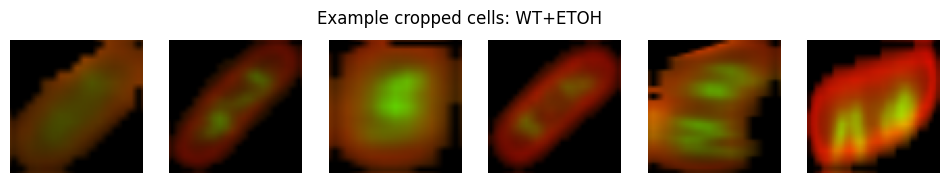

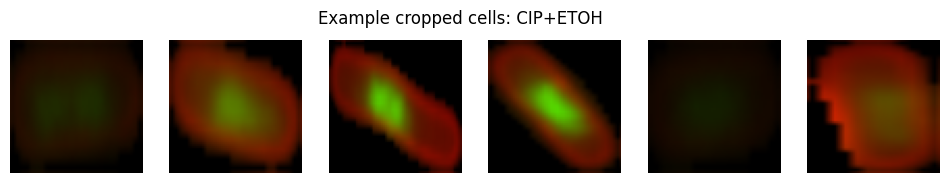

/tmp/ipython-input-3498489639.py:360: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  sampler = optuna.samplers.TPESampler(seed=42, multivariate=True)
[I 2026-01-22 14:46:22,250] A new study created in memory with name: no-name-fa9d1557-8e7d-4f23-8746-11b929a4d53d


WT+ETOH: mean intensity ~ 27.21 (std 11.33)
CIP+ETOH: mean intensity ~ 23.76 (std 9.83)
Starting Optuna study. Base dir: ./models/classification/optuna_EfficientNetB0_WT_ETOH_CIP_ETOH_20260122-144622
16705208/16705208 [==============================] - 2s 0us/step


DataGenerator - supplied 3200 images, batch size 4
DataGenerator - approx 800.0 batches available.
DataGenerator - generating images of size (64, 64, 3)
Epoch 1/40


/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


800/800 - 130s - loss: 0.7153 - accuracy: 0.6397 - val_loss: 0.4201 - val_accuracy: 0.8562 - 130s/epoch - 162ms/step
Epoch 2/40
800/800 - 60s - loss: 0.5658 - accuracy: 0.7281 - val_loss: 0.4450 - val_accuracy: 0.8100 - 60s/epoch - 76ms/step
Epoch 3/40


In [ ]:
import os
import sys
import numpy as np

# Ensure legacy Keras 2 API for pipeline modules
os.environ.setdefault('TF_USE_LEGACY_KERAS', '1')
try:
    import tf_keras
    sys.modules['keras'] = tf_keras
except Exception:
    pass

# Ensure we are in the repo root and the pipeline is importable.
from pathlib import Path

def _find_repo_root():
    here = Path.cwd()
    candidates = [here, *here.parents]
    for name in (
        'Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing',
        'Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main',
    ):
        candidates.append(here / name)
    for p in candidates:
        if (p / 'pipeline' / 'helpers.py').exists():
            return p
    raise FileNotFoundError('Repo root not found (missing pipeline/helpers.py). Re-run the clone cell.')

repo_root = _find_repo_root()
os.chdir(repo_root)
print('Repo root:', repo_root)

pipeline_dir = str(repo_root / 'pipeline')
if pipeline_dir not in sys.path:
    sys.path.insert(0, pipeline_dir)

import importlib
import helpers
import classification
importlib.reload(helpers)
importlib.reload(classification)
from classification import struct_from_file, split_cell_sets, train, cells_from_struct
from datetime import datetime

from pathlib import Path

# Build a real (labeled) single-cell dataset from the downloaded `Zagajewski_Data` (MG1655)
# Section 4 shows this structure exists:
#   ./data/Zagajewski_Data/Data/MG1655/All_images/<COND>/*.tif
#   ./data/Zagajewski_Data/Data/MG1655/All_segmentations/<COND>/*.tif
# We'll turn the integer-encoded segmentation masks into single-cell instance masks, then crop cells and train.

RAW_ROOT = Path('./data/Zagajewski_Data/Data/MG1655')
IMAGES_ROOT = RAW_ROOT / 'All_images'
SEGS_ROOT = RAW_ROOT / 'All_segmentations'
if not (IMAGES_ROOT.exists() and SEGS_ROOT.exists()):
    raise FileNotFoundError('MG1655 data not found under ./data/Zagajewski_Data/Data/MG1655. Run the download/unzip + Section 4 listing first.')

available_conditions = sorted({p.name for p in IMAGES_ROOT.iterdir() if p.is_dir()} & {p.name for p in SEGS_ROOT.iterdir() if p.is_dir()})
print('Available MG1655 conditions:', available_conditions)

# Pick the conditions you want to classify (two-class by default). Edit this list.
COND_IDS = ['WT+ETOH', 'CIP+ETOH']
for cond in COND_IDS:
    if cond not in available_conditions:
        raise ValueError(f'Condition {cond!r} not found. Choose from: {available_conditions}')

def _slug(s: str) -> str:
    return ''.join(ch if ch.isalnum() else '_' for ch in s)

# IMPORTANT (leakage): we split by *image* first (Train/Validation/Test), then crop cells inside each split.
# Do not re-split at the single-cell level, otherwise cells from the same microscope image can leak across splits.
TEST_SIZE = 0.10
VAL_SIZE = 0.20  # fraction of the remaining Train+Val pool used for Validation (see implementations.TrainTestVal_split)
DATASET_OUT = Path('./data') / (
    f"classifier_dataset_mg1655_{'__'.join(_slug(c) for c in COND_IDS)}_t{int(TEST_SIZE*100)}_v{int(VAL_SIZE*100)}"
)
OUTPUT_CLASSIFIER_DIR = './models/classification'
os.makedirs(OUTPUT_CLASSIFIER_DIR, exist_ok=True)

import mask_generators
import implementations
importlib.reload(mask_generators)
importlib.reload(implementations)
from mask_generators import masks_from_integer_encoding
from implementations import TrainTestVal_split

# Ensure single-cell instance masks exist for each condition
image_sources = []
annot_sources = []
for cond in COND_IDS:
    img_dir = IMAGES_ROOT / cond
    seg_dir = SEGS_ROOT / cond
    annots_dir = seg_dir / 'annots'

    if not annots_dir.exists() or not any(annots_dir.iterdir()):
        print(f'Generating single-cell masks for {cond}...')
        masks_from_integer_encoding(mask_path=str(seg_dir), output_path=str(seg_dir), combined_convention=False)

    image_sources.append(str(img_dir))
    annot_sources.append(str(annots_dir))

# Create a standard dataset layout (Train/Validation/Test) if needed
train_split = DATASET_OUT / 'Train'
val_split = DATASET_OUT / 'Validation'
test_split = DATASET_OUT / 'Test'
if not ((train_split / 'images').exists() and (train_split / 'annots').exists()):
    print('Creating classification dataset at:', DATASET_OUT)
    TrainTestVal_split(
        data_sources=image_sources,
        annotation_sources=annot_sources,
        output_folder=str(DATASET_OUT),
        test_size=TEST_SIZE,
        validation_size=VAL_SIZE,
        seed=42,
    )

# Sanity check: ensure image-level splits are disjoint
def _image_ids(split_root: Path):
    p = split_root / 'images'
    if not p.exists():
        return set()
    return {f.name for f in p.iterdir() if f.is_file()}

train_ids = _image_ids(train_split)
val_ids = _image_ids(val_split)
test_ids = _image_ids(test_split)
print('Image files (train/val/test):', len(train_ids), len(val_ids), len(test_ids))
print('Overlaps:', {'train∩val': len(train_ids & val_ids), 'train∩test': len(train_ids & test_ids), 'val∩test': len(val_ids & test_ids)})
assert len(train_ids & test_ids) == 0 and len(train_ids & val_ids) == 0 and len(val_ids & test_ids) == 0

# Convert folder-of-instance-masks -> cropped single-cell images (streaming; RAM-safe)
#
# IMPORTANT: `struct_from_file(...)` loads *all* masks into RAM and can easily exceed Colab's ~12GB limit.
# This streaming approach only keeps up to `N_PER_CLASS` crops per class in memory.
import re
import gc
import skimage
import skimage.io
from skimage.transform import resize

# Optionally cap the number of cell crops per class to keep system RAM bounded.
# Set to a smaller number (e.g. 200-1000) if you still hit OOM. Set to None to use all cells (can OOM).
N_PER_CLASS = 2000
# Keep this in sync with the model input size below.
CROP_TARGET_SIZE = (64, 64, 3)

def _find_image_path(images_root: Path, annot_folder_name: str) -> Path:
    candidates = [
        images_root / annot_folder_name,
        images_root / (Path(annot_folder_name).stem + '.tif'),
        images_root / (Path(annot_folder_name).stem + '.tiff'),
    ]
    for p in candidates:
        if p.exists():
            return p
    raise FileNotFoundError(f'No image found for annot folder {annot_folder_name!r} under {images_root}')

def _match_cond(name: str, cond_ids: list[str]) -> str | None:
    matches = []
    for cond in cond_ids:
        if re.search(re.escape(cond), name) is not None:
            matches.append(cond)
    return matches[0] if len(matches) == 1 else None

def _crop_cells_streaming(dataset_root: Path, cond_ids: list[str], max_per_class: int | None, seed: int = 42):
    rng_local = np.random.default_rng(seed)
    images_root = dataset_root / 'images'
    annots_root = dataset_root / 'annots'
    if not (images_root.exists() and annots_root.exists()):
        raise FileNotFoundError(f'Expected {images_root} and {annots_root} to exist.')

    out = {'class_id_to_name': []}
    for i, cond in enumerate(cond_ids):
        out[cond] = []
        out['class_id_to_name'].append({'class_id': i, 'name': cond})

    kept = {cond: 0 for cond in cond_ids}
    removed_edge = 0
    skipped_nomatch = 0

    annot_dirs = [p for p in annots_root.iterdir() if p.is_dir()]
    rng_local.shuffle(annot_dirs)

    for annot_dir in annot_dirs:
        cond = _match_cond(annot_dir.name, cond_ids)
        if cond is None:
            skipped_nomatch += 1
            continue
        if max_per_class is not None and kept[cond] >= max_per_class:
            continue

        img_path = _find_image_path(images_root, annot_dir.name)
        image = skimage.io.imread(str(img_path))
        if image.ndim == 2:
            image = image[..., None]

        # Ensure 3 channels for ImageNet backbones (DenseNet/ResNet/VGG).
        if image.shape[-1] == 1:
            image = np.repeat(image, 3, axis=-1)
        elif image.shape[-1] > 3:
            image = image[..., :3]

        sy, sx = image.shape[:2]

        mask_files = [p for p in annot_dir.iterdir() if p.suffix.lower() == '.bmp']
        rng_local.shuffle(mask_files)

        for mask_path in mask_files:
            if max_per_class is not None and kept[cond] >= max_per_class:
                break

            mask = skimage.io.imread(str(mask_path))
            mask = np.asarray(mask)
            if mask.ndim == 3:
                # Some readers return RGB; collapse to a single channel.
                mask = mask.max(axis=-1)
            # Support both 0/1 and 0/255 saved masks.
            mask = mask > 0
            if not mask.any():
                continue

            ys, xs = np.where(mask)
            y1, y2 = int(ys.min()), int(ys.max()) + 1  # y2 exclusive
            x1, x2 = int(xs.min()), int(xs.max()) + 1  # x2 exclusive

            # Mirror `helpers.remove_edge_cells()` semantics (Mask R-CNN rois are exclusive at y2/x2).
            on_edge = (y1 == 0) or (x1 == 0) or (y2 == 0) or (x2 == 0) or (y1 >= sy) or (x1 >= sx) or (y2 >= sy) or (x2 >= sx)
            if on_edge:
                removed_edge += 1
                continue

            roi = mask[y1:y2, x1:x2]
            crop = image[y1:y2, x1:x2, :].copy()
            crop *= roi[..., None]

            # Resize early so every sample is the same (small) size -> much lower RAM.
            crop = resize(crop, CROP_TARGET_SIZE, anti_aliasing=True)
            crop = skimage.img_as_ubyte(crop)
            out[cond].append(crop)
            kept[cond] += 1

        if max_per_class is not None and all(kept[c] >= max_per_class for c in cond_ids):
            break

    return out, removed_edge, skipped_nomatch

# Crop cells separately per split (prevents leakage across Train/Val/Test)
N_PER_CLASS_TRAIN = N_PER_CLASS
N_PER_CLASS_VAL = min(1000, N_PER_CLASS)  # lower by default to save RAM; set to None for all
N_PER_CLASS_TEST = None  # set to an int to cap RAM usage

cells_train, removed_train, skipped_train = _crop_cells_streaming(dataset_root=train_split, cond_ids=COND_IDS, max_per_class=N_PER_CLASS_TRAIN, seed=42)
cells_val, removed_val, skipped_val = _crop_cells_streaming(dataset_root=val_split, cond_ids=COND_IDS, max_per_class=N_PER_CLASS_VAL, seed=43)
cells_test, removed_test, skipped_test = _crop_cells_streaming(dataset_root=test_split, cond_ids=COND_IDS, max_per_class=N_PER_CLASS_TEST, seed=44)

print('Removed edge cells (train/val/test):', removed_train, removed_val, removed_test)
if skipped_train or skipped_val or skipped_test:
    print('WARNING: skipped annotation folders with ambiguous/no cond match:', {'train': skipped_train, 'val': skipped_val, 'test': skipped_test})

for split_name, cells_split in [('train', cells_train), ('val', cells_val), ('test', cells_test)]:
    print('---', split_name, '---')
    for cond in COND_IDS:
        print(cond, 'cells:', len(cells_split[cond]))

def _to_xy(cells_struct):
    X, y = [], []
    for mapping in cells_struct['class_id_to_name']:
        cond = mapping['name']
        cid = int(mapping['class_id'])
        X.extend(cells_struct[cond])
        y.extend([cid] * len(cells_struct[cond]))
    return X, np.asarray(y, dtype='int32')

X_train, y_train = _to_xy(cells_train)
X_val, y_val = _to_xy(cells_val)
X_test, y_test = _to_xy(cells_test)
print('Split sizes:', {'train': len(X_train), 'val': len(X_val), 'test': len(X_test)})

if any(len(cells_train[c]) == 0 for c in COND_IDS):
    raise ValueError('No cells were extracted for one or more classes in TRAIN. Check masks/images alignment.')
if any(len(cells_val[c]) == 0 for c in COND_IDS):
    print('WARNING: one or more classes have 0 cells in VALIDATION (split may be too small).')
if any(len(cells_test[c]) == 0 for c in COND_IDS):
    print('WARNING: one or more classes have 0 cells in TEST (split may be too small).')

gc.collect()

# Sanity checks: if accuracy is near chance, first confirm the crops look correct.
min_cells = min(len(cells_train[c]) for c in COND_IDS)
if min_cells < 1000:
    print('WARNING: very few cells per class; accuracy will likely be low. Consider using more data (N_PER_CLASS=None) or different conditions.')

import matplotlib.pyplot as plt

rng = np.random.default_rng(42)

def _plot_examples(label, imgs, n=6):
    if not imgs:
        return
    k = min(n, len(imgs))
    idx = rng.choice(len(imgs), size=k, replace=False)
    fig, axs = plt.subplots(1, k, figsize=(2*k, 2))
    fig.suptitle(f'Example cropped cells: {label}')
    if k == 1:
        axs = [axs]
    for ax, i in zip(axs, idx):
        img = imgs[i]
        if getattr(img, 'ndim', 0) == 3 and img.shape[-1] >= 3:
            ax.imshow(img[..., :3])
        else:
            ax.imshow(np.squeeze(img), cmap='gray')
        ax.axis('off')
    plt.show()

for cond in COND_IDS:
    _plot_examples(cond, cells_train[cond], n=6)

def _mean_intensity(imgs, n=200):
    if not imgs:
        return 0.0, 0.0
    k = min(n, len(imgs))
    idx = rng.choice(len(imgs), size=k, replace=False)
    vals = [float(np.asarray(imgs[i]).mean()) for i in idx]
    return float(np.mean(vals)), float(np.std(vals))

for cond in COND_IDS:
    mean_i, std_i = _mean_intensity(cells_train[cond])
    print(f'{cond}: mean intensity ~ {mean_i:.2f} (std {std_i:.2f})')

# `N_PER_CLASS_*` sampling happens above (during streaming collection), to avoid loading the full dataset into RAM.

# Model / training defaults
MODEL_TYPE = 'EfficientNetB0'
INIT_SOURCE = 'imagenet'  # ImageNet pretrained weights
TARGET_SIZE = CROP_TARGET_SIZE
NUM_CLASSES = len(COND_IDS)
BATCH_SIZE = 4
EPOCHS = 100
OPTIMIZER = 'NAdam'

if len(X_train) < BATCH_SIZE:
    raise ValueError(f'Too few training samples ({len(X_train)}) for batch_size={BATCH_SIZE}. Reduce batch_size or increase N_PER_CLASS.')

# Optuna: Bayesian optimization (TPE sampler) + pruning
DO_OPTUNA = True
N_TRIALS = 25
EPOCHS_TUNE = 40

best_params = None
if DO_OPTUNA:
    import optuna

    tune_dt = datetime.now().strftime('%Y%m%d-%H%M%S')
    tune_name = f"optuna_{MODEL_TYPE}_{'_'.join(_slug(c) for c in COND_IDS)}_{tune_dt}"
    TUNE_DIR = os.path.join(OUTPUT_CLASSIFIER_DIR, tune_name)
    os.makedirs(TUNE_DIR, exist_ok=True)
    print('Starting Optuna study. Base dir:', TUNE_DIR)

    sampler = optuna.samplers.TPESampler(seed=42, multivariate=True)
    pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
    study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)

    def objective(trial):
        dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.6)
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 3e-3, log=True)
        patience = trial.suggest_int('patience', 3, 12)

        trial_dt = f"trial_{trial.number:03d}"
        trial_logdir = os.path.join(TUNE_DIR, trial_dt)
        os.makedirs(trial_logdir, exist_ok=True)

        return train(
            mode=MODEL_TYPE,
            X_train=X_train,
            y_train=y_train,
            X_val=X_val,
            y_val=y_val,
            size_target=TARGET_SIZE,
            class_count=NUM_CLASSES,
            logdir=trial_logdir,
            verbose=False,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS_TUNE,
            learning_rate=learning_rate,
            optimizer=OPTIMIZER,
            init_source=INIT_SOURCE,
            dropout_rate=dropout_rate,
            early_stopping_patience=patience,
            use_lr_scheduler=False,
            plot_diagnostics=False,
            val_seed=42,
            trial=trial,
            prune_monitor='val_accuracy',
            return_best=True,
            return_best_monitor='val_accuracy',
            pad_cells=False,
        )

    study.optimize(objective, n_trials=N_TRIALS)
    print('Best trial:', study.best_trial.number)
    print('Best params:', study.best_trial.params)
    best_params = study.best_trial.params
else:
    best_params = {'dropout_rate': 0.2, 'learning_rate': 3e-4, 'patience': 8}

LEARNING_RATE = float(best_params['learning_rate'])
DROPOUT = float(best_params['dropout_rate'])
PATIENCE = int(best_params['patience'])

dt_string = datetime.now().strftime('%Y%m%d-%H%M%S')
run_name = f"{MODEL_TYPE}_{'_'.join(_slug(c) for c in COND_IDS)}_{dt_string}"
LOG_DIR = os.path.join(OUTPUT_CLASSIFIER_DIR, run_name)
os.makedirs(LOG_DIR, exist_ok=True)
print('Starting final classification training. Log dir:', LOG_DIR)
print('Params:', {'lr': LEARNING_RATE, 'dropout': DROPOUT, 'patience': PATIENCE})

train(
    mode=MODEL_TYPE,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    eval_test_each_epoch=True,
    size_target=TARGET_SIZE,
    class_count=NUM_CLASSES,
    logdir=LOG_DIR,
    verbose=False,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    optimizer=OPTIMIZER,
    init_source=INIT_SOURCE,
    dropout_rate=DROPOUT,
    early_stopping_patience=PATIENCE,
    use_lr_scheduler=False,
    val_seed=42,
    dt_string=dt_string,
    pad_cells=False,
)

print('Training finished.')

# Hold-out test evaluation (10%)
from keras.models import load_model
from keras.utils import to_categorical
import skimage
from imgaug import augmenters as iaa

model_path = os.path.join(LOG_DIR, dt_string + '.h5')
model = load_model(model_path)
X_test_arr = skimage.img_as_ubyte(np.asarray(X_test))
histeq_aug = iaa.Sequential([iaa.AllChannelsHistogramEqualization()])
X_test_arr = histeq_aug(images=X_test_arr)
try:
    from keras.applications.efficientnet import preprocess_input as _eff_preprocess_input
    X_test_arr = _eff_preprocess_input(X_test_arr.astype(np.float32))
except Exception:
    try:
        from tensorflow.keras.applications.efficientnet import preprocess_input as _eff_preprocess_input
        X_test_arr = _eff_preprocess_input(X_test_arr.astype(np.float32))
    except Exception:
        X_test_arr = X_test_arr.astype(np.float32)

y_test_cat = to_categorical(np.asarray(y_test, dtype='int32'), NUM_CLASSES)
test_loss, test_acc = model.evaluate(X_test_arr, y_test_cat, verbose=0)
print('Hold-out test:', {'loss': float(test_loss), 'acc': float(test_acc)})

## 7. Next Steps

After successful training, your model weights (`.h5` files) will be saved in the specified output directories (e.g., `./models/segmentation` and `./models/classification`).

You can then use these `.h5` files in your `web_app/app.py` to integrate the deep learning pipeline with your web application.